# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [107]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [108]:
### Replace each question mark with the appropriate value.
import numpy as np
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Label :  30


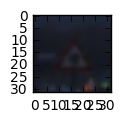

In [109]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

def visualize(X_train, y_train) :
        index = random.randint(0, len(X_train))
        image = X_train[index].squeeze()
        
        plt.figure(figsize=(1,1))
        plt.imshow(image)        

        print('Label : ',y_train[index])
        
visualize(X_train, y_train)


# Dataset Class : 
The library member 'class Dataset' (see bellow) return a Dataset of features and labels by taking as input an url and the name of the repository. It offers the following features :
    1.download : download the zip file from an url
    2.uncompress : uncommpres the zip file and extract the pickle file to a given repository
    3.load : load the dataset from the pickle file in memory
    4.visualize : show randomly feature and label
    5.give statistics on dataset : 
                5.1.the number of lable or feature per class
                5.2.the number of the class in the dataset
                5.3.the shape of the feature and label
                5.4.the class which has the max number of label and feature (useful when augmenting the dataset)
    6.balance : 

In [110]:
import os
import random
import pickle
#import wget 
from urllib.request import urlretrieve
from  urllib.request import urlopen
import urllib.error 
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
from enum import Enum, unique
import inspect
from PIL import Image
from tqdm import tqdm
from zipfile import ZipFile
from tensorflow.python.ops.variables import Variable
from functools import partial
from itertools import groupby
import pycuda
import pycuda.driver as cuda
import scipy.ndimage
%matplotlib inline

print('All modules imported.')

source = 'https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip'
repository = 'traffic-signs-data.zip'
batch_count = 128
rate = 0.001
EPOCHS = 50
BATCH_SIZE = 150

All modules imported.


In [111]:
class Dataset(object):
    def __init__(self,source, repository):
        
        print('Status of Initialization Step #0')
        if source is None:
            print('None source parameter is not allowed. Please, provide a source parameter.')
            return None
        if len(source)==0:
            print("Empty source parameter is not allowed. Please, provide a valid source parameter.")
            return None
        if repository is None:
            print('None repository parameter is not allowed. Please, provide a repository parameter.')
            return None
        if len(repository)==0:
            print("Empty repository parameter is not allowed. Please, provide a valid repository parameter.")
            return None
        
        
        self.__source = source
        self.__repository=repository
        self.__datacached,self.__dataloaded = False,False
        self.__downloaded , self.__uncompressed = 0,0
        self.train_size, self.test_size,self.class_size,self.label_per_class = 0,0,0,[]
        self.image_shape = None
        self.max_size_feature = [0,0]
        
    def __wget(self, source, repository):
        try:
            print(source)
            content = urlopen(source)
            repository = open(source.split('/')[-1], 'w')
            repository.write(content.read())
            content.close()
            repository.close()
        except Exception as err:
            print('ERROR:', str(err))
            raise 
        
    
    def __download(self):
        print('Download Step #1')
        #print(self.__source)
        for src, rep in tqdm(zip(self.__source, self.__repository)):
            try :
                if not os.path.isfile(rep):
                    print('Start download files from '+src+'...')
                    urlretrieve(src,rep)
                    #rep = wget.download(src)
                    #self.__wget(src,rep)
                    print('Download finished.')
                    self.__downloaded += 1
                else :
                    print('Repository path '+rep+ ' is file! We can not save\
                            files because no directory path is provided.')
            except urllib.error.URLError: #Exception as inst : #
                    print('file not found corresponding to ' + src +'. moving on...')
                    raise
                    
        if self.__downloaded != 0 :
            print('Status of download Step : ' +str(self.__downloaded) + ' files are downloaded over '+\
                      str(len(self.__source)))
            
    def __uncompress(self):
        print('Uncompression Step #3')
        destfiles=[]
        for path in self.__repository :
        #Instantiate zipfile class as zipf context
            #print(path)
            with ZipFile(path,'r') as zipf:
                #extracting file name list using progressbar
                pbfiles = zipf.namelist()
                for fname in tqdm(pbfiles, unit='files'):
                    #check whether  file name do not point to a directory. Thus do not process it 
                    if not fname.endswith('/'):
                        #unzip the image file using the file name
                        print('Unzip the image file '+fname)
                        #with zipf.open(fname) as file:
                        zipf.extract(fname)

                        # Now store the uncompressed data
                        #fdest = fname[:-3]  # remove the '.gz' from the filename
                        #print(fdest)
                        destfiles.append(fname)
                        
            print('Status of uncompression Step :  '+ str(self.__uncompressed)+ \
                      'files are uncompressed over' +str(len(pbfiles)))
        destfiles = sorted(destfiles,key=os.path.getsize, reverse=True)
        return np.array(destfiles) 
    
    def __load(self,pkfile):
        # Reload the data
        print('Data Loading Step #4')
        train_features,train_labels = None,None
        if os.path.isfile(pkfile):
            #print(pkfile)
            with open(pkfile, 'rb') as f:
              pickle_data = pickle.load(f)
              features = pickle_data['features']
              labels = pickle_data['labels']
              del pickle_data  # Free up memory
            print('Status of Data loading from pickle file Step : successful')
            self.__dataloaded = True
        else :
            print('Status of Data loading from pickle file Step : failed')
        return features,labels
    
    def deserialize(self):
        desfiles = []
        print('The dataset deserialization process is starting...')
        
        if self.__downloaded==0:
            self.__download()
            
        if self.__uncompressed == 0:
            desfiles = self.__uncompress()
            
        if len(desfiles)==2 :
            train_features, train_labels = self.__load(desfiles[0])
            test_features,test_labels = self.__load(desfiles[1])
            self.train_size = train_features.shape[0]
            self.test_size = test_features.shape[0]
            self.image_shape = (train_features.shape[1],train_features.shape[2],train_features.shape[3])
            self.class_size = np.unique(train_labels).size
            self.label_per_class = np.array([(k,len(list(v))) for k,v in groupby(train_labels)])
           
            for t in self.label_per_class:
                
                if(self.max_size_feature[1]<t[1]):
                    self.max_size_feature = t
            
            
        print('The dataset deserialization process is terminated...')
        
        return train_features,train_labels, test_features,test_labels
    
    def visualize(self, X_train, y_train) :
        index = random.randint(0, len(X_train))
        image = X_train[index].squeeze()

        plt.figure(figsize=(1,1))
        plt.imshow(image)
        print(y_train[index])
        
    def __max(self, X_train, y_train, augmenter):
        #Define the max(class,label/feature)
        
        for t in self.label_per_class:
            if(self.max_size_feature[1]<t[1]):
                self.max_size_feature = t
    
    def balance(self,X_train,y_train,augmenter,args):
        #for each (class,feature/label) different from max, 
        # augment(class, feature/label) by the amount of tuple = max(class,feature) - nb(class,feature)
        # Adjust(class, label)
        # Append(Augmented(class,feature), train_feature)
        #params = (1,1)
        #print((augmenter) (*params))
        augfeatures,auglabels =[],[]
        
        start=0
        for t in self.label_per_class:
            augfeatures.append(X_train[t[1]])
            auglabels.append(y_train[t[1]])
            if t[1]!=self.max_size_feature[1]:
                compensation = self.max_size_feature[1]-t[1]
                print(compensation)
                for i in range(compensation-1):
                    bf = X_train[start:start+t[1]]
                    bl = y_train[start:start+t[1]]
                    args = (bf,args[1])
                    ft = (augmenter)(*args)
                    augfeatures.append(ft)
                    auglabels.append(bl)
                    start += t[1]
                    
        return augfeatures,auglabels
                

In [112]:
'''
sources = [source]
repositories = [repository]

ds = Dataset(sources, repositories)
X_train, y_train,X_test, y_test = ds.deserialize()
print("Number of training examples =", ds.train_size)
print("Number of testing examples =", ds.test_size)
print("Image data shape =", ds.image_shape)
print("Number of classes =", ds.class_size)
print("Number of label_per_class =", ds.label_per_class)

#ds.visualize(X_train, y_train)
'''

'\nsources = [source]\nrepositories = [repository]\n\nds = Dataset(sources, repositories)\nX_train, y_train,X_test, y_test = ds.deserialize()\nprint("Number of training examples =", ds.train_size)\nprint("Number of testing examples =", ds.test_size)\nprint("Image data shape =", ds.image_shape)\nprint("Number of classes =", ds.class_size)\nprint("Number of label_per_class =", ds.label_per_class)\n\n#ds.visualize(X_train, y_train)\n'

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

# Data Preprocessing

The preprocess stage aims to :
    1.Split the train dataset into train dataset and validation datase.
    2.Normalize data

1.Split the train dataset into train dataset and validation dataset. If the number of input data is insuffisiant we can add more data using the Data augmentation process. For the purpose of this project, i propose to generate more data for the train and test datasets using the data augmenter and split randomly the augmented train dataset into a new train dataset and a validation dataset.


2.Data Normalization : in order to make the learning process performing better. The CNN learns its weights by adding gradient error vectors multiplied by the learning rate computed from backprop to weight matrices as the training process is running. so we end up with the following equation :
W = W + (learningrate * gradient descent)

Initial conditions : At the begining of the learning process, the input features values distributions are different for each one (feature). Thus the learning rate would correct in each dimension from one another. it might be over compensating a correction in one weight dimension while undercompensating in another.

The gradient descent find itself oscillating and unable to center or moving slowly  onto a better minima. So therefore, to reach a better minima and avoiding the oscillation (see above)  we need to normalize the input features values.

The scenario for preprocessing dataset is based on dataset normalization using three following methods to compare the average error (%) for each (http://ijssst.info/Vol-15/No-2/data/3251a024.pdf §IV. RESULTS AND DISCUSSIONS.)

The methods are :
    1.Simple Rescale
    2.Substract Mean 
    3.Feature Standardization


Each normalization methods is implemented by a "normalized" pipeline (see "class DataPreProcessor" bellow).
The normalization is part of the preprocess stage and should be applied after the Data augmentation stage (see later "class DataAugmenter") if exists.




In [113]:
class DataPreProcessor(object):
    '''
    http://cs231n.github.io/neural-networks-2/#datapre
    There are three common forms of data preprocessing a data matrix X, 
    where we will assume that X is of size [N x D] (N is the number of data, D is their dimensionality).
    '''
    
    class Tasks(object):
        SimpleRescale = 'simple_rescale'
        MeanSubstract = 'mean_substract'
        FeatureStandardization = 'feature_standardization'
        
    class Normalizer(object):
        
        def _simple_rescale(self,images):
            images /= 255
            return images
        
        def _mean_substract(self,images):
            print('_zero_centred')
            print(images.dtype)
            #np.mean(images, axis = 0,dtype=np.uint8)
            images -= np.mean(images, axis = 0,dtype=np.uint8)
            return images
        
        def _feature_standardization(self, images):
            print('_normalize')
            images /= np.std(images, axis = 0)
            return images
        
    class Sequential(object):
        
        def __init__(self, sequence):
            self.sequence = sequence
        
        def preprocess_images(self,images):
            print(self.sequence)
            obj = self.sequence[0]
            #self.sequence.remove(obj)
            
            for seq in self.sequence :
                if seq != obj:
                    images = getattr(obj, seq)(images)
                
            return images
    
    def __init__(self):
        self.pipeline = []
        ppc = self.Normalizer()
        self.pipeline.append(ppc)
    
    def simple_rescale(self):
        if not "_simple_rescale" in  self.pipeline:
            self.pipeline.append("_simple_rescale") 
    
    def mean_substract(self):
        if not "_mean_substract" in  self.pipeline:
            self.pipeline.append("_mean_substract") 
        
    def feature_standardization(self):
        if "_feature_standardization" in  self.pipeline :
            self.pipeline.append("_feature_standardization") 
        
    def register(self,tasks):
        #print('Preprocessor Pipeline registration process is starting ...')
        if tasks is None:
            print('None tasks parameter is not allowed. Please, provide a tasks parameter.')
            return None
        if len(tasks)==0:
            print("Empty tasks parameter is not allowed. Please, provide a valid tasks parameter.")
            return None
        
        self.tasks = tasks
        
        methnames = [m for m in dir(self) if inspect.ismethod(getattr(self, m))]                     
        #print(methnames)
        #print(tasks)
        for taskname in tasks :                         
            if taskname not in methnames:
                print('The following method does not exists: ', taskname)
                return
        for taskname in tasks :
            self.__getattribute__(taskname)()
        
        #print('Preprocessor Pipeline registration process is terminated ...')
        
    def execute(self, images, show=False):
        #print('Preprocessor Pipeline execution process is starting ...')
        pline = self.Sequential(self.pipeline)
        
        imgs = pline.preprocess_images(images)
        
        if show :
            # show an image with 8*8 augmented versions of image 0
            seq.show_grid(imgs[0], cols=8, rows=8)

        #print('Preprocessor Pipeline execution process is terminated ...')
        
        return imgs
    
    def preprocess(self, X_train, y_train, apply=False) :
        dpp = self #DataPreProcessor()
        pipeline = [dpp.Tasks.MeanSubstract,dpp.Tasks.FeatureStandardization]
        dpp.register(pipeline)
        #batch_features = X_train
        #batch_features, batch_labels  = load_batch(0,X_train, y_train)
        
        batch = []
        for image in X_train:
            batch.append(dpp.execute(image))
            
        return batch
        '''
        if apply :
            return dpp.execute(batch_features) # images_aug = dpp.execute(batch_features)
        else:
            return batch_features #images_aug = batch_features
            print('Not Apply')
        '''
        #train_on_images(images_aug)
        '''
        for idx,image in enumerate(images_aug):
            plt.figure(figsize=(1,1))
            plt.imshow(image)
            print(batch_labels[idx])
        '''

In [114]:
#apply_preprocessing(X_train, y_train,True) 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

# Data Augmentation and Spliting

The DataAugmenter class library provides a way to generate more data from the existing and thus makes cnn or dnn to trained on huge number of training dataset to reach better performance and accuracy

This library class is a data augmenter pipeline manager using the Augmenters Module referenced at this url:
    https://github.com/aleju/imgaug
This class use different image processing to provide more images to the dataset. for eeach image in the dataset the DataAugmenter pipeline apply randomly image processing operations to generate a new one and add it to the dataset. The Algorithm to follow in order to obtain more data images is :
    * The Dataset class has a method called "balance" implement the following algorithm :
        * It checks for each the difference class difference of images missed regarding the class which the maximum number.
        * for each (class,feature/label) different from max, 
        * augment(class, feature/label) by the amount of tuple = max(class,feature) - nb(class,feature)
        * Adjust(class, label)
        * Append(Augmented(class,feature), train_feature)

In [115]:
'''
1: Data Augmentation
    This technique provides a way genrerate more data from the existing and thus makes cnn or dnn to be 
    trained on huge number of training dataset to reach better performance and accuracy.
'''

class DataAugmenter(object):
    '''
    This library class is a data augmenter pipeline manager using the Augmenters Module referenced at this url:
    https://github.com/aleju/imgaug
   '''
    class Tasks(object):
        def __str__(self):
            return str(self.value)
        
        FlipVertical = 'flip_vertical'
        FlipHorizontal = 'flip_horizontal'
        Crop = 'crop'
        GaussianBlur = 'gaussian_blur'
        AdditiveGaussianNoise = 'additive_gaussian_noise'
        Dropout = 'dropout'
        Add = 'add'
        Multiply = 'multiply'
        ContrastNormalization = 'contrast_normalization'
        Affine = 'affine'
        ElasticTransformation = 'elastic_transformation'
        
        
    def __init__(self):
        
        # random example images
        #images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)

        # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
        # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
        self.st = lambda aug: iaa.Sometimes(0.5, aug)
        self.pipeline = []
        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.tasks = []
    
    def flip_horizontal(self):
        # horizontally flip 50% of all images
        if not "iaa.Fliplr" in self.pipeline:
            self.pipeline.append(iaa.Fliplr(0.5))
            
    def flip_vertical(self):
        # vertically flip 50% of all images
        if not "iaa.Flipud"  in self.pipeline:
            self.pipeline.append(iaa.Flipud(0.5))
            
    def crop(self):
        # crop images by crop range of 0-10%  of their height/width
        if not "iaa.Crop" in self.pipeline:
            self.pipeline.append(self.st(iaa.Crop(percent=(0, 0.1))))
    
    def gaussian_blur(self):
        # blur images with a sigma range between 0 and 3.0
        if not "iaa.GaussianBlur" in self.pipeline:
            self.pipeline.append(self.st(iaa.GaussianBlur((0, 3.0))))
    
    def additive_gaussian_noise(self):
        # add gaussian noise to images
        if "iaa.AdditiveGaussianNoise" in self.pipeline:
            self.pipeline.append(self.st(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.2), per_channel=0.5)))
    
    def dropout(self):
        # randomly remove up to 10% of the pixels  
        if not "iaa.Dropout" in self.pipeline:
            self.pipeline.append(self.st(iaa.Dropout((0.0, 0.1), per_channel=0.5)))
    
    def add(self):
        # change brightness of images (by -10 to 10 of original value)
        if not "iaa.Add" in self.pipeline:
            self.pipeline.append(self.st(iaa.Add((-10, 10), per_channel=0.5)))
    
    def multiply(self):
        # change brightness of images (50-150% of original value)
        if not "iaa.Multiply" in self.pipeline:
            self.pipeline.append(self.st(iaa.Multiply((0.5, 1.5), per_channel=0.5)))
        
    def contrast_normalization(self):
        # improve or worsen the contrast
        if not "iaa.ContrastNormalization" in self.pipeline:
            self.pipeline.append(self.st(iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)))
    
    def affine(self):
        
        if not "iaa.Affine" in self.pipeline:
            self.pipeline.append(self.st(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    translate_px={"x": (-16, 16), "y": (-16, 16)}, # translate by -16 to +16 pixels (per axis)
                    rotate=(-45, 45), # rotate by -45 to +45 degrees
                    shear=(-16, 16), # shear by -16 to +16 degrees
                    order=ia.ALL, # use any of scikit-image's interpolation methods
                    cval=(0, 1.0), # if mode is constant, use a cval between 0 and 1.0
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )))
            
    def elastic_transformation(self):
        # apply elastic transformations with random strengths
        if not "iaa.ElasticTransformation" in self.pipeline:
            self.pipeline.append(self.st(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)))
    
        
    def register(self,tasks):
        #Allow to register the tailored data augmentation pipeline        
        print('Augmenter Pipeline registration process is starting ...')
        if tasks is None:
            print('None tasks parameter is not allowed. Please, provide a tasks parameter.')
            return None
        if len(tasks)==0:
            print("Empty tasks parameter is not allowed. Please, provide a valid tasks parameter.")
            return None
        
        self.tasks = tasks
        
        methnames = [m for m in dir(self) if inspect.ismethod(getattr(self, m))]                     

        for taskname in tasks :                         
            if taskname not in methnames:
                print('The following method does not exists: ', taskname)
                return
        for taskname in tasks :
            self.__getattribute__(taskname)()
        
        print('Augmenter Pipeline registration process is terminated ...')
    
    def execute(self, images, show=False):
        print('Augmenter Pipeline execution process is starting ...')
        pline = iaa.Sequential(self.pipeline, 
                             random_order = True # do all of the above in random order
                                )                         
        augmented_images = pline.augment_images(images)
        
        if show :
            # show an image with 8*8 augmented versions of image 0
            seq.show_grid(images[0], cols=8, rows=8)

        print('Augmenter Pipeline execution process is terminated ...')
        
        return augmented_images
    
    def augmente(self,X_train) :
    
        da = self #DataAugmenter()
        tasks = []
        '''
        tasks = [da.Tasks.FlipHorizontal,da.Tasks.FlipVertical,da.Tasks.Crop,
                    da.Tasks.GaussianBlur,da.Tasks.Dropout,
                 da.Tasks.Affine,da.Tasks.ElasticTransformation]
        '''
        tasks.append(da.Tasks.FlipHorizontal)
        #tasks.append(da.Tasks.FlipVertical)
        #tasks.append(da.Tasks.Crop)
        #tasks.append(da.Tasks.GaussianBlur)
        #tasks.append(da.Tasks.Dropout)
        #tasks.append(da.Tasks.Affine)
        #tasks.append(da.Tasks.ElasticTransformation)

        
        
        da.register(tasks)
        
        return da.execute(X_train)
        
        '''
        batch_features, batch_labels  = self.load_batch(0,X_train, y_train)

        if apply :
            images_aug = da.execute(batch_features)
        else:
            images_aug = batch_features
            print('Not Apply')
        #train_on_images(images_aug)

        for idx,image in enumerate(images_aug):
            plt.figure(figsize=(1,1))
            plt.imshow(image)
            print(batch_labels[idx])
        '''
        
    def load_batch(self, batch_i,train_features,train_labels):
        batch_size = 1000 #train_features/batch_count
        # The training cycle
        #for batch_i in range(batch_count):
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        batch_features = train_features[batch_start:batch_start + batch_size]
        batch_labels = train_labels[batch_start:batch_start + batch_size]
        return batch_features, batch_labels   


def apply_augmentation2(batch_features, apply=False) :
    
    da = DataAugmenter()
    
    tasks = [da.Tasks.FlipHorizontal,da.Tasks.FlipVertical,da.Tasks.Crop,
                da.Tasks.GaussianBlur,da.Tasks.Dropout,
             da.Tasks.Affine,da.Tasks.ElasticTransformation]
    
    da.register(tasks)
    
    #batch_features, batch_labels  = load_batch(0,X_train, y_train)
    batch = []
    for image in X_train:
        batch.append(da.execute(image))

    return batch
    
    '''
    if apply :
        images_aug = da.execute(batch_features)
    else:
        images_aug = batch_features
        print('Not Apply')
        
    '''
    
    #train_on_images(images_aug)
    '''
    for idx,image in enumerate(images_aug):
        plt.figure(figsize=(1,1))
        plt.imshow(image)
        #print(batch_labels[idx])
    '''
    
    #print(len(images_aug))
    
    #return images_aug


        

In [116]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
#args = (None,True)
#ds.balance(X_train,y_train,partial(apply_augmentation2),args)

In [117]:
from abc import ABCMeta, abstractmethod
import collections
import tensorflow as tf
from tensorflow.contrib.layers import flatten

class Layer(object):
    __metaclass__ = ABCMeta

    def __init__(self):
        self._input=None
        self._output=None
        
    @property
    def input(self):
        return self._input
        
    @input.setter
    def input(self,val):
        _input_setter(val)
    
    @abstractmethod
    def _input_setter(self,val):
        pass
    
    @property
    def output(self):
        return self._output
    '''
    @output.setter
    def output(self,val):
        _output_setter(val)
        
    @abstractmethod
    def _output(self,val):
        pass
    '''
    
    @abstractmethod
    def compute(self,images):pass
        
class Convolutional(Layer):
    #def __init__(self,stride,ksize,padding,sigma,mu):
    def __init__(self,params):
        
        print(params)
        print('stride : ',params['stride'])
        assert(params['stride']!=None or not len(params['stride'])==0),"None or empty stride parameter is not allowed. Please, provide a stride parameter"
        assert(params['ksize'] !=None or not len(params['ksize'])==0),"None or empty ksize parameter is not allowed. Please, provide a ksize parameter"
        assert(params['padding'] !=None or not len(params['padding'])==0),"None or empty padding parameter is not allowed. Please, provide a padding parameter"
        assert(params['sigma'] !=None),"None  sigma parameter is not allowed. Please, provide a sigma parameter"
        assert(params['mu']!=None ),"None mu parameter is not allowed. Please, provide a mu parameter"
        
        self.stride = params['stride']
        self.ksize = params['ksize']
        self.weights = None
        self.biais = None
        self.sigma = params['sigma']
        self.mu = params['mu']
        self.padding = params['padding']
        
    def _input_setter(self,val):
        assert(val !=None or not len(val)==0),"None or empty val parameter is not allowed. Please, provide a val parameter"
        self._input = val
        
    def compute(self, images):
        assert(images !=None or not len(images)==0),"None or empty images parameter is not allowed. Please, provide a images parameter"
        self.weights = tf.Variable(tf.truncated_normal(shape = self.ksize, mean = self.mu, stddev = self.sigma))
        self.biais = tf.Variable(tf.zeros(self.ksize[3]))
        print('images :',images)
        print('weights :',self.weights)
        print('biais :',self.biais)
        return tf.nn.conv2d(images, self.weights, strides=self.stride, padding=self.padding) + self.biais

class  Activation(Layer):
    def __init__(self):
        pass
    
    def _input_setter(self,val):
        assert(val !=None or not len(val)==0),"None or empty val parameter is not allowed. Please, provide a val parameter"
        self._input = val
    
    def compute(self,images):
        assert(images !=None or not len(images)==0),"None or empty images parameter is not allowed. Please, provide a images parameter" 
        return tf.nn.relu(images)
        
class Pooling(Layer):
    def __init__(self,params):
        assert(params['stride'] !=None or not len(params['stride'])==0),"None or empty stride parameter is not allowed. Please, provide a source parameter"
        assert(params['ksize'] !=None or not len(params['ksize'])==0),"None or empty ksize parameter is not allowed. Please, provide a ksize parameter"
        assert(params['padding'] !=None or not len(params['padding'])==0),"None or empty padding parameter is not allowed. Please, provide a padding parameter"
                
        self.stride = params['stride']
        self.ksize = params['ksize']
        self.padding = params['padding'] 
    
    def _input_setter(self,val):
        assert(val==None or len(val)==0),"None or empty input parameter is not allowed. Please, provide a input parameter"
        self._input = val
        
    def compute(self,images):
        assert(images !=None or not len(images)==0),"None or empty images parameter is not allowed. Please, provide a images parameter"
        return tf.nn.max_pool(images, ksize=self.ksize, strides=self.stride, padding=self.padding)
        
class Flattening(Layer):
    def __init__(self):
        pass
    
    def compute(self,images):
        assert(images !=None or not len(images)==0),"None or empty images parameter is not allowed. Please, provide a images parameter" 
        return flatten(images)
        
class FullyConnected(Layer):
    def __init__(self,params):
        assert(params['ksize'] !=None or not len(params['ksize'])==0),"None or empty ksize parameter is not allowed. Please, provide a ksize parameter"
        assert(params['sigma'] !=None),"None  sigma parameter is not allowed. Please, provide a sigma parameter"
        assert(params['mu'] !=None ),"None mu parameter is not allowed. Please, provide a mu parameter"
        assert(params['keep_probe'] !=None ),"None keep_probe parameter is not allowed. Please, provide a keep_probe parameter"
        
        self.ksize = params['ksize']
        self.weights = None
        self.biais = None
        self.sigma = params['sigma']
        self.mu = params['mu']
        self.keep_prob = params['keep_probe']
    
    def _input_setter(self,val):
        assert(val !=None or not len(val)==0),"None or empty val parameter is not allowed. Please, provide a val parameter"
        self._input = val
        
    def compute(self,images):
        assert(images !=None or not len(images)==0),"None or empty images parameter is not allowed. Please, provide a images parameter" 
        self.weights = tf.Variable(tf.truncated_normal(shape=self.ksize, mean = self.mu, stddev = self.sigma))
        self.biais = tf.Variable(tf.zeros(self.ksize[1]))
        images = tf.nn.dropout(images, self.keep_prob)
        return tf.matmul(images, self.weights) + self.biais
    
   
        
        
class Model(object):
    
    class Tasks(object):
        Convolve = 'convolve'
        Activate = 'activate'
        Pool = 'pool'
        Flatten = 'flatten'
        FullConnect = 'fullconnect'
    
    class Sequential(object):
        def __init__(self, sequence):
            self.sequence = sequence
        
        def run_pipeline(self,images):
            obj = self.sequence.get_value('obj__1')
            self.sequence.remove('obj__1')
            
            for taskname in self.sequence.get_keys() :
                print(taskname)
                tsk = taskname.split('__')[0]
                print('tsk :',tsk)
                images = getattr(obj, tsk)(self.sequence.get_value(taskname),images)
                print('tensor :',images)
                
            return images
        
    class Container(object):
        
        def __init__(self):
            self._dic = collections.OrderedDict()
            
            self.identifier = 0

        def __get_id(self):
            self.identifier += 1
            return '__' + str(self.identifier)
        
        def insert(self, key,value):
            assert(not value == None ),"None or empty value parameter is not allowed. Please, provide a value parameter" 
            __key = key+self.__get_id()
            self._dic[__key] = value
                        
        def update(self, key,value):
            assert(not key == None or key>0),"None or empty key parameter is not allowed. Please, provide a key parameter" 
            assert(not value == None),"None or empty value parameter is not allowed. Please, provide a value parameter" 
            self._dic[key] = value
        
        def remove(self,key):
            assert(not key == None or key>0),"None or empty key parameter is not allowed. Please, provide a key parameter" 
            del self._dic[key]
            
        def remove_all(self, key):
            assert(not key == None or key>0),"None or empty key parameter is not allowed. Please, provide a key parameter" 
            self._dic.clear()
        
        def get_keys(self):
            return self._dic.keys()
        
        def get_value(self,key):
            return self._dic[key]
        
        
            
    
    def __init__(self):
        
        self.pipeline = self.Container() #[]
        #self.tasks = Container() #[]
        self.pipeline.insert('obj',self)
        self.logits = None
        
    #stride,ksize,padding,sigma,mu
    #stride,ksize,padding
    def _convolve(self,params,images):
        conv = Convolutional(params)
        return conv.compute(images)
    
    def _activate(self, params,images):
        act = Activation()
        return act.compute(images)
    
    def _pool(self, params, images):
        pl=Pooling(params)
        return pl.compute(images)
    
    def _flatten(self, params, images):
        fl = Flattening()
        return fl.compute(images)
    
    def _fullconnect(self, params, images):
        fc = FullyConnected(params)
        return fc.compute(images)
    
    def convolve(self,params):
        #if not "_convolve" in  self.pipeline.keys():
        #self.pipeline.append("_convolve") 
        self.pipeline.insert('_convolve',params)
   
    def activate(self,params):
        #if not "_activate__"+index in  self.pipeline.keys():
        self.pipeline.insert('_activate',params)
    
    def pool(self,params):
        #if not "_pool__"+index in  self.pipeline.keys():
        self.pipeline.insert('_pool',params)
    
    def flatten(self,params):
        #if not "_flatten__"+index in  self.pipeline.keys():
        self.pipeline.insert('_flatten',params)
    
    def fullconnect(self,params):
        #if not "_fullconnect__"+index in  self.pipeline.keys():
        self.pipeline.insert('_fullconnect',params)
    
    
    def register(self,tasks):
        #Allow to register the tailored data augmentation pipeline        
        print('Model Pipeline registration process is starting ...')
        if tasks is None:
            print('None tasks parameter is not allowed. Please, provide a tasks parameter.')
            return None
        if len(tasks.get_keys())==0:
            print("Empty tasks parameter is not allowed. Please, provide a valid tasks parameter.")
            return None
        
        self.tasks = tasks
        
        methnames = [m for m in dir(self) if inspect.ismethod(getattr(self, m))]                     

        for taskname in tasks.get_keys():  
            taskname=taskname.split('_')[0]
            if taskname not in methnames:
                print('The following method does not exists: ', taskname)
                return
        for taskname in tasks.get_keys() :
            # taskname.split('_')[0] : methodname
            #taskname : key of dictionary
            self.__getattribute__(taskname.split('_')[0])(tasks.get_value(taskname))
        
        print('Model Pipeline registration process is terminated ...')
        
    def execute(self, images, show=False):
        print('Model Pipeline execution process is starting ...')
        pline = self.Sequential(self.pipeline)
        
        self.logits = pline.run_pipeline(images)
        
        if show :
            # show an image with 8*8 augmented versions of image 0
            seq.show_grid(imgs[0], cols=8, rows=8)

        print('Model Pipeline execution process is terminated ...')
    
    
    
    def build(self,images,classize,keep_prob) :

        #images = tf.placeholder(tf.float32, shape)

        #model = Model()
        pipeline = self.Container()

        print('# SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.')
        # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
        params = dict()
        params['stride'] = [1, 1, 1, 1]
        params['ksize'] = (3, 3, 3,128) #(5, 5, 3, 6)
        params['padding'] = 'VALID'
        params['sigma'] = 0.1
        params['mu'] = 0
        pipeline.insert(self.Tasks.Convolve,params)  #stride,ksize,padding,sigma,mu

        print('# SOLUTION: Activation.')
        # SOLUTION: Activation.
        pipeline.insert(self.Tasks.Activate,0) 

        '''
        print('# SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.')
        # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
        params = dict()
        params['stride'] = [1, 2, 2, 1]
        params['ksize'] = [1, 2, 2, 1]
        params['padding'] = 'VALID'
        pipeline.insert(self.Tasks.Pool,params) #stride,ksize,padding
        
        
        print('# SOLUTION: Layer 2: Convolutional. Output = 10x10x16.')
        # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
        params = dict()
        params['stride'] = [1, 1, 1, 1]
        params['ksize'] = (5, 5, 10, 20) #(5, 5, 6, 16)
        params['padding'] = 'VALID'
        params['sigma'] = 0.1
        params['mu'] = 0
        pipeline.insert(self.Tasks.Convolve, params) #stride,ksize,padding,sigma,mu

        print('# SOLUTION: Activation.')
        # SOLUTION: Activation.
        pipeline.insert(self.Tasks.Activate,0)


        print('# SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.')
        # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
        params = dict()
        params['stride'] = [1, 2, 2, 1]
        params['ksize'] = [1, 2, 2, 1]
        params['padding'] = 'VALID'
        pipeline.insert(self.Tasks.Pool, params) #stride,ksize,padding
        
        '''

        print('# SOLUTION: Flatten. Input = 5x5x16. Output = 400.')
        # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
        pipeline.insert(self.Tasks.Flatten, 0)

        print('# SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.')
        # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
        params = dict()
        params['ksize'] = (115200, 1024) #(400, 120)
        params['sigma'] = 0.1
        params['mu'] = 0
        params['keep_probe'] = keep_prob # probability to keep units
        pipeline.insert(self.Tasks.FullConnect,params) #ksize,sigma,mu

        print('# SOLUTION: Activation.')
        # SOLUTION: Activation.
        pipeline.insert(self.Tasks.Activate, 0)


        print('# SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.')
        # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
        params = dict()
        params['ksize'] = (1024,1024) #(120, 84)
        params['sigma'] = 0.1
        params['mu'] = 0
        params['keep_probe'] = keep_prob # probability to keep units
        pipeline.insert(self.Tasks.FullConnect, params) #ksize,sigma,mu

        print('# SOLUTION: Activation.')
        # SOLUTION: Activation.
        pipeline.insert(self.Tasks.Activate,0)
        
        '''
        print('# SOLUTION: Activation.')
        # SOLUTION: Activation.
        pipeline.insert(self.Tasks.Activate,0)
        '''

        print('# SOLUTION: Layer 5: Fully Connected. Input = 84. Output = classize.')
        # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
        params = dict()
        params['ksize'] = (1024, classize) #(84, classize)
        params['sigma'] = 0.1
        params['mu'] = 0
        params['keep_probe'] = keep_prob # probability to keep units
        pipeline.insert(self.Tasks.FullConnect,params) #ksize,sigma,mu


        print(pipeline)
        self.register(pipeline)

        #batch_features, batch_labels  = load_batch(0,X_train, y_train)

        self.execute(images)

    
def load_batch(batch_i,train_features,train_labels):
    batch_size = 1000 #train_features/batch_count
    # The training cycle
    #for batch_i in range(batch_count):
    # Get a batch of training features and labels
    batch_start = batch_i*batch_size
    batch_features = train_features[batch_start:batch_start + batch_size]
    batch_labels = train_labels[batch_start:batch_start + batch_size]
    return batch_features, batch_labels   
            
    

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My model uses LeNet Lab as starting point :
1/Convolutional Layer Input = 32x32x3 (3 channels), stride=1, filter=(5,5,3,10), Output = 28x28x10
2/Activation Layer 
3/Pooling Layer Input = 28x28x10, stride=1, kernel=(1,2,2,1), Output = 14x14x10
4/Convolutional Layer Input = 14x14x10, stride=(1, 1, 1, 1), filter=(5, 5, 10, 20) Output = 10x10x20
5/Activation Layer 
6/Pooling Layer Input = 10x10x20,stride=(1, 2, 2, 1) kernel=(1, 2, 2, 1), Output = 5x5x20
7/Flatten input = 5x5x20, output = 500
8/Fully Connected with added dropout input = 500, output = 160
9/Activation 
10/Fully Connected with added dropout Layer input = 120, output = 60
11/Activation 
12/fully connected with added dropout layer input = 84, outpput= 43

In [118]:
### Train your model here.io
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
class Trainer(object):
    def __init__(self,rate,epochs,batch_size,x,y,logits,keep_probe,graph):
        assert(not rate == None or rate>1),"None or greater than one rate parameter is not allowed. Please, provide a rate parameter" 
        assert(not epochs == None or epochs>=1),"None or greater than one epochs parameter is not allowed. Please, provide a epochs parameter" 
        assert(not batch_size == None or batch_size>1),"None or greater than one batch_size parameter is not allowed. Please, provide a batch_size parameter" 
        assert(not x == None),"None or greater than one x parameter is not allowed. Please, provide a x parameter" 
        assert(not y == None),"None or greater than one y parameter is not allowed. Please, provide a y parameter" 
        assert(not logits == None),"None or greater than one logits parameter is not allowed. Please, provide a logits parameter" 
        self.rate = rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.training_operation = None
        #self.saver = saver #tf.train.Saver()
        self.y = y
        self.x = x 
        self.logits = logits
        self.one_hot_y = None
        self.val_keep_prob = 1
        self.test_keep_prob = 0.5
        self.keep_prob = keep_probe
        self.graph = graph
        self.session = tf.Session('', self.graph)
        
    def build_pipeline(self, classsize):
        assert(not classsize == None),"None or empty one_hot_y parameter is not allowed. Please, provide a one_hot_y parameter" 
        self.one_hot_y = tf.one_hot(self.y, classsize)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.one_hot_y)
        loss_operation = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = self.rate)
        self.training_operation = optimizer.minimize(loss_operation)
        
    
    def evaluate(self, X_data, y_data,keep_probe):
        assert(not X_data == None),"None or empty X_data parameter is not allowed. Please, provide a X_data parameter" 
        assert(not y_data == None),"None or empty y_data parameter is not allowed. Please, provide a y_data parameter" 
        
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(accuracy_operation, feed_dict={self.x: batch_x, self.y: batch_y, \
                                                               self.keep_prob:keep_probe})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
    def train_model(self,X_train, y_train):
        assert(not X_train == None),"None or empty X_train parameter is not allowed. Please, provide a X_train parameter" 
        assert(not y_train == None),"None or empty y_train parameter is not allowed. Please, provide a y_train parameter" 
        
        #da = DataAugmenter()
        
        dummy = tf.Variable(0)  # dummy variable !!!
        with self.session as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train)
            #dpp = DataPreProcessor()
            print("Training...")
            print()
            
            validation_size = int(num_examples * 0.1)
            train_size = num_examples - validation_size
            
            for i in range(self.epochs):
                X_train, y_train = shuffle(X_train, y_train)
                for offset in range(0, train_size, self.batch_size):
                    end = offset + self.batch_size
                    #batch_x, batch_y = dpp.preprocess(X_train[offset:end],None,False), y_train[offset:end]
                    #for b in X_train[offset:end]:
                        
                  
  
                    batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={self.x: batch_x, self.y: batch_y,\
                                                                 self.keep_prob:self.val_keep_prob})
                
                #validation_size = int(num_examples * 0.3)
                #print('validation_size :',validation_size)
                #print('difference :', int(num_examples-validation_size))
                
                #validation_start = random.randint(0,int(num_examples-validation_size))
                validation_start = train_size + 1
                validation_end = validation_start + validation_size
                print('validation_start : ',validation_start)
                
                '''
                X_validation, y_validation = da.augmente(X_train[validation_start:validation_end]) , \
                                            y_train[validation_start:validation_end]
                '''
                X_validation, y_validation = X_train[validation_start:validation_end] , \
                                            y_train[validation_start:validation_end]
                validation_accuracy = self.evaluate(X_validation, y_validation,self.test_keep_prob)
                print("EPOCH {} ...".format(i+1))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                print()
            saver = tf.train.Saver()
            saver.save(sess, './lenet')
            print("Model saved")
    
    def test_model(self,X_test, y_test):
        assert(not X_test == None),"None or empty X_test parameter is not allowed. Please, provide a X_test parameter" 
        assert(not y_test == None),"None or empty y_test parameter is not allowed. Please, provide a y_test parameter" 
        #dummy = tf.Variable(0)  # dummy variable !!!
        with tf.Session('', self.graph) as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.import_meta_graph('./lenet.meta')
            #saver.restore(sess, tf.train.latest_checkpoint('.'))
            ckpt = str(tf.train.latest_checkpoint('.')) #tf.train.get_checkpoint_state('.')
            print(ckpt)
            if ckpt:
                saver.restore(sess, ckpt)
                print('Restored!')
                test_accuracy = self.evaluate(X_test, y_test,self.test_keep_prob)
                print("Test Accuracy = {:.3f}".format(test_accuracy))
            


In [119]:
def preprocess(X_train, y_train):
    print('Generating additional data...')
    angles = [-5, 5, -10, 10, -15, 15, -20, 20]
    
    inputs_per_class = np.bincount(y_train)
    max_inputs = np.max(inputs_per_class)

    for i in range(len(inputs_per_class)):
        input_ratio = min(int(max_inputs / inputs_per_class[i]) - 1, len(angles) - 1)

        if input_ratio <= 1:
            continue

        new_features = []
        new_labels = []
        mask = np.where(y_train == i)

        for j in range(input_ratio):
            for feature in X_train[mask]:
                new_features.append(scipy.ndimage.rotate(feature, angles[j], reshape=False))
                new_labels.append(i)

        X_train = np.append(X_train, new_features, axis=0)
        y_train = np.append(y_train, new_labels, axis=0)

    # Normalize features
    print('Normalizing features...')
    X_train = X_train / 255. * 0.8 + 0.1

    '''
    # Get randomized datasets for training and validation
    print('Randomizing datasets...')
    from sklearn.model_selection import train_test_split
    X_train, valid_features, train_labels, valid_labels = train_test_split(
       train_features,
       train_labels,
       test_size=0.2,
       random_state=832289
    )
    '''
    print('Data preprocessed')
    return X_train, y_train


def train_or_test(operation):
    sources = [source]
    repositories = [repository]

    ds = Dataset(sources, repositories)
    X_train, y_train,X_test, y_test = ds.deserialize()
    print("Number of training examples =", ds.train_size)
    print("Number of testing examples =", ds.test_size)
    print("Image data shape =", ds.image_shape)
    print("Number of classes =", ds.class_size)
    print("Max size of label_per_class =", ds.max_size_feature)
    ds.visualize(X_train, y_train)
    graph = tf.Graph()
    with graph.as_default():
        x = tf.placeholder(tf.float32, (None, 32, 32, 3))
        y = tf.placeholder(tf.int32, (None))
        keep_probe = tf.placeholder(tf.float32)
        model = Model()
        model.build(x,ds.class_size,keep_probe)
        print('logits : ', model.logits)
        trainer = Trainer(rate,EPOCHS,BATCH_SIZE,x,y,model.logits,keep_probe,graph)
        trainer.build_pipeline(ds.class_size)

        if operation == 'train' :
            X_train,y_train = preprocess(X_train, y_train)
            trainer.train_model(X_train, y_train)
            trainer.test_model(X_test, y_test)
        if operation == 'test' :
            trainer.test_model(X_test, y_test)

                       
#train_or_test('train')
#train_or_test('test')

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Train library is wrapper around tensorflow methods to encapsulate all of the training procedures of the model in one single method called train_model. This method has the following attributes:

1/ rate = 0.001
2/ EPOCHS = 10
3/ BATCH_SIZE = 128
4/ Hyperparameters : 
    4.1/ Conv layer #1 
            Number of filters = 128
            filter size = (5,5)
    4.2/ Relu Layer #1
    4.3/ Flatten
            
    4.4/ FC 1024
    4.5/ FC 1024
    4.6/ FC 43
            


implement the following workflow :
*/ Training data is drouped out using a parameter keep_prob = 0.5 for the validation training step and keep_prob=1.0 for the testing step
*/ Training data is normalized and augmented
*/for each batch of 128 examples, 
    */trained using an Adam optimizer because it uses Kingma and Ba's Adam algorithm to control the learning rate. Adam offers several advantages over the simple tf.train.GradientDescentOptimizer. http://stats.stackexchange.com/questions/184448/difference-between-gradientdescentoptimizer-and-adamoptimizer-tensorflow
    
    */Creates a validation dataset using 30% of the size of training dataset and the data augementer library. The advantages of this technique is taking a copy of each choosen training example and augment it which leads to not reduce the training dataset size. To do that for each epochs, the starting element of the validation dataset is calculated randomly.
    */Validation accuracy is then calculated and displayed.
    
   

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

The approach taken to solve this problem is a derived architecture of LeNet. 
I tried first the following architecture : Conv/Relu/Pool/Relu/Conv/Relu/Pool/Relu/Flatten/FC/FC/FC. The results were poor after many attemps of tweaking the Hyperparamters accuracy was under 50% after many trials 
So i changed the network architecture by samplifying it. I kept only one conv layer and three FCs layers. I modify three times  the batch size until 150 which make the validation accuracy over 89% local minima with no stucking to. The final parameters are :
learning rate = 0.001
Batch size = 150
Epochs = 100



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [120]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def load_images(path):

    imgnames = ['01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg']

    images = np.float32(np.zeros((10,32,32,3)))
    
    for idx,name in enumerate(imgnames):
        image = mpimg.imread(path + name)
        #image = image.resize((int(width),int(height)),Image.ANTIALIAS)
        print(image.shape)
        images[idx-1]=image
        plt.imshow(image)
        plt.show()
    
    #images =  np.array(images)
    return images   
    
#images = load_images('images/')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**


(32, 32, 3)


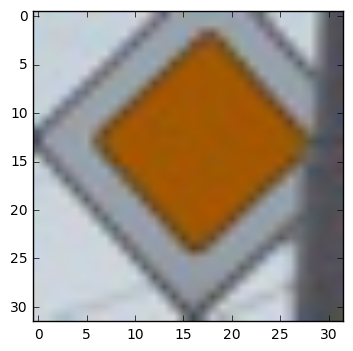

(32, 32, 3)


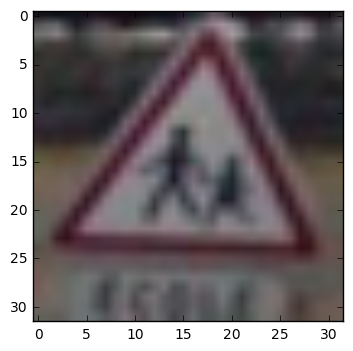

(32, 32, 3)


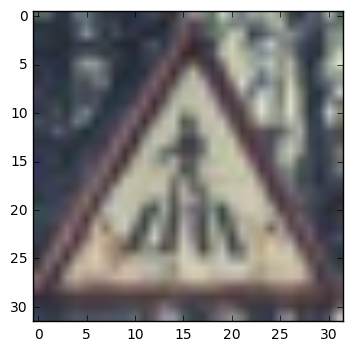

(32, 32, 3)


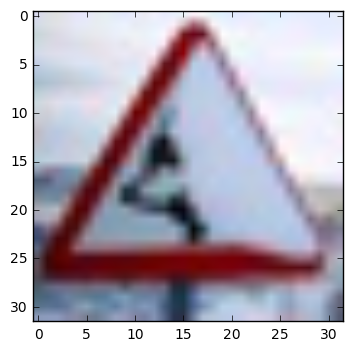

(32, 32, 3)


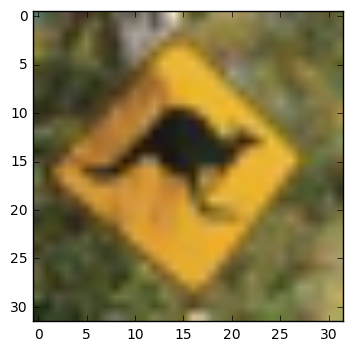

images :  (10, 32, 32, 3)
./lenet
Restored!
# SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
# SOLUTION: Activation.
# SOLUTION: Flatten. Input = 5x5x16. Output = 400.
# SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
# SOLUTION: Activation.
# SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
# SOLUTION: Activation.
# SOLUTION: Layer 5: Fully Connected. Input = 84. Output = classize.
Model Pipeline registration process is starting ...
Model Pipeline registration process is terminated ...
Model Pipeline execution process is starting ...
_convolve__2
tsk : _convolve
{'padding': 'VALID', 'mu': 0, 'ksize': (3, 3, 3, 128), 'sigma': 0.1, 'stride': [1, 1, 1, 1]}
stride :  [1, 1, 1, 1]
images : Tensor("Placeholder_3:0", shape=(10, 32, 32, 3), dtype=float32)
weights : Tensor("Variable_9/read:0", shape=(3, 3, 3, 128), dtype=float32)
biais : Tensor("Variable_10/read:0", shape=(128,), dtype=float32)
tensor : Tensor("add_4:0", shape=(10, 30, 30, 128)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_4' with dtype float
	 [[Node: Placeholder_4 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_4', defined at:
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-121-d083f516aa3b>", line 18, in <module>
    keep_probe = tf.placeholder(tf.float32)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1587, in placeholder
    name=name)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/naaman/anaconda3/envs/CTSC/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_4' with dtype float
	 [[Node: Placeholder_4 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [121]:
## Run the predictions here.
### Feel free to use as many code cells as needed.
images = load_images('images/')
print('images : ',images.shape)
graph = tf.Graph()
     
        
with tf.Session('', tf.Graph()) as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.import_meta_graph('./lenet.meta')
            #saver.restore(sess, tf.train.latest_checkpoint('.'))
            ckpt = str(tf.train.latest_checkpoint('.')) #tf.train.get_checkpoint_state('.')
            print(ckpt)
            if ckpt:
                saver.restore(sess, ckpt)
                print('Restored!')
                x = tf.placeholder(tf.float32, (10,32, 32, 3))
                keep_probe = tf.placeholder(tf.float32)
                model = Model()
                model.build(x,43,keep_probe)
                prediction = tf.nn.softmax(model.logits)

                with tf.Session() as session:
                    new_predictions = session.run(prediction, feed_dict={x: images})
                    top_k = session.run(tf.nn.top_k(new_predictions, 5, sorted=True))
                    print("Predicted Labels")
                    print(np.argmax(new_predictions, 1))

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.